# Anomaly detection in energy storage systems.

# Overview
Renewable energy sources have become one of the significant factors contributing to new energy generation construction.

One of the critical components of renewables is Energy Storage Systems that allow to conserve energy during peak production hours and release it when energy generation is limited. This helps to solve the problem of stability of energy generation from renewable sources of energy.

Safety is a critical question for Energy storage systems. Failure of one cell leads to a thermal runaway that results in the unstoppable chemical fire inside Energy Storage System that results in complete site destruction. https://www.spglobal.com/marketintelligence/en/news-insights/latest-news-headlines/burning-concern-energy-storage-industry-battles-battery-fires-51900636

While system failure can't be predicted because it depends on many factors, including cell internal structure damages, some factors contribute to it. 

Some of them:

- avoiding over-discharge and overcharge of batteries

- control of cell temperature.

One of the challenges is that the Energy Storage system consists of hundreds of thousands of cells, each with a temperature and voltage sensor that generates an enormous amount of information. For example, https://pv-magazine-usa.com/2022/02/15/mce-approves-100mw-solar-plus-storage-project-in-california/ 
This project capacity is 75MWh It will require installation of at least 190 000 battery cells (up to 500 000 depends on technology that will be used) each of them will provide information about their status.




# Business Understanding
Our stakeholder wants to have a model that can analyze the status of 10 000+ cells during commissioning and annual service works. This model should identify abnormal behavior of cells that can lead to hazards during further operations.

Abnormal behavior:

Too low/high voltage sensors readings.

Too low/high-temperature sensor readings

Current imbalance during charge/discharge.

Our model should accept raw data provided from BMS(Battery management system) systems manufactured by BMester (one of the key suppliers).

The model should be easy to use and interpret results by commissioning engineers.

# Data

1) Sensor readings that weere taken from 5 cluster systems taken in June 2021 during commissioning works.


# Metrics
#### Our project will answer following question:
Can we forecast sensor readings limits and automatically identify cells that are out of limits for further investigation. 

#### Hypothesis:
H0 - Anomaly in cell

HA - There is statistically significant proof that there is no anomaly in the cell.

#### TP, TN, FP, FN definition

TP - We predicted anomaly, and it does exist

TN - We predicted that there is no anomaly and it doesn't exist

FP - We predicted an anomaly, but there was no anomaly.

FN - We predicted that there is no anomaly,  but it existed.


#### Metrics used  
To compare models, we will focus on two primary metrics:

Recall - Missing any anomaly case can lead to Hazard. Therefore, we are focused on finding as much as possible.

Accuracy - how well we can predict TP and TN. These are general metrics that will show model performance.

##### While it is impossible to say that the actual identified case will lead to Hazard, it is crucial to find and mark cells for further investigation of service engineers.





# Data Understanding
#### Sources of data:
1) Chest X-Ray Images. Year: 2018 
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

https://data.mendeley.com/datasets/rscbjbr9sj/3

#### Main dataset contains the following images:
Train set:

There are 1349 normal images, image name example, NORMAL-2552119-0002.jpeg

There are 4489 pneumonia images, image name example, BACTERIA-4038442-0001.jpeg

Test set:

There are 234 normal images, image name example, NORMAL-8698006-0001.jpeg

There are 390 pneumonia images, image name example, VIRUS-2040583-0001.jpeg


# Data Cleaning
### Importing required modules

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import re
#import cv2



%matplotlib inline


# Work with data
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


#Modeling
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import timedelta



#Other
import pickle
import time
import os, shutil 
from PIL import Image
from scipy import ndimage
import itertools

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import zipfile
import os
#import cv2

# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
# simplefilter(action='ignore', category= FutureWarning)
# simplefilter(action='ignore', category= ConvergenceWarning)
# simplefilter(action='ignore', category= FitFailedWarning)
# simplefilter(action='ignore', category= UserWarning)

### Data preparation

Below we create three objects representing the existing directories: `data/normal/` as `data_normal_dir` and `data/pneumonia/` as `data_pneumonia_dir`, `data/test/normal/` as `test/normal` and `data/test/pneumonia/` as `test/pneumonia`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `normal` and `pneumonia` subfolders. The final desired structure is represented below: 

![title](images/folder_structure.png)

In [2]:
# config
class config:
    def __init__(self):
        self.low_voltage_th = -3
        self.low_voltage_alarm = -2
        self.high_voltage_th = 3
        self.high_voltage_alarm = 2
        self.low_temperature = 100
        self.high_temperature = 100
        self.high_mean_temperature_alarm = 400
        self.low_mean_temperature_alarm = 50
        self.low_voltage_n_std = 3
        self.low_voltage_alarm_n_std = 2
        self.high_voltage_n_std = 3
        self.high_voltage_alarm_n_std = 2
        self.sensor_v_prec = 5
        self.period_h = 12


# low_voltage_th = -3
# low_voltage_alarm = -2
# high_voltage_th = 3
# high_voltage_alarm = 2
# low_temperature = 100
# high_temperature = 100
# high_mean_temperature_alarm = 400
# low_mean_temperature_alarm = 50
conf = config()
sns.set_style("whitegrid")
markers = ["*", "<", "v","^","p",">","s","p","o", "*", "<", "v","^","p",">","s","p" ]
cmap = plt.get_cmap('Dark2')

In [3]:
# Data folder
raw_folder = "raw/"

In [4]:
# Files inside
files = [file for file in os.listdir(raw_folder) if file.endswith("csv")]

In [5]:
#os.listdir(raw_folder)

In [6]:
# make list of paths
list_paths = [raw_folder + file for file in files]
list_paths

['raw/vol1 20210610 19.csv',
 'raw/vol1 20210610 18.csv',
 'raw/vol1 20210610 17.csv']

In [7]:
# Create timeseries from files inside the folder
def create_dataframe(list_paths, df_type = "voltage", resample_time= "30S"):
    # read
    files = [list_paths + file for file in os.listdir(list_paths) if file.endswith("csv")]
    df_type = df_type.lower()
    reg = re.compile(df_type)
    dataframe = [pd.read_csv(file) for file in files]
    final_df = pd.concat(dataframe, axis = 0)
    final_df["MCGS_TIME"] = pd.to_datetime(final_df["MCGS_TIME"])
    final_df = final_df.set_index("MCGS_TIME")
    drop_columns = [column for column in final_df.columns.str.lower() if not bool(re.match(reg, column))]
    final_df.columns = final_df.columns.str.lower()
    final_df= final_df.drop(drop_columns, axis = 1)
    final_df = final_df.resample(resample_time).mean().bfill()
    return final_df



In [8]:
# dataframe = [pd.read_csv(path) for path in list_paths]
# final_df = pd.concat(dataframe, axis = 0)
# final_df["MCGS_TIME"] = pd.to_datetime(final_df["MCGS_TIME"])
# final_df = final_df.set_index("MCGS_TIME")
# drop_columns = [column for column in final_df.columns.str.lower() if "voltage" not in column]
# # final_df= final_df.drop(drop_columns, axis = 1)
# # final_df = final_df.resample("30S").mean().bfill()

In [9]:
# # Find clusters
# clusters = [cluster for cluster in os.listdir(raw_folder) if "cluster" in cluster]
# # Prepare path for each cluster
# clusters_paths = [(raw_folder + cluster + "/", cluster) for cluster in clusters]
# # Check data sources in each cluster
# os.listdir(clusters_path[0][0])
# # Divide it cluster to different types of data
# voltage_paths = [(cluster_parth[0]+"voltage/", cluster_parth[1]) for cluster_parth in clusters_paths]
# temperature_paths = [(cluster_parth[0]+"temperature/", cluster_parth[1]) for cluster_parth in clusters_paths]
# state_paths = [(cluster_parth[0]+"total state/", cluster_parth[1]) for cluster_parth in clusters_paths]

# # Create datasets
# df_voltage_list = [create_dataframe(voltage_path[0], "[a-zA-Z0-9_]+voltage") for voltage_path in voltage_paths]
# df_temperature_list = [create_dataframe(temperature_path[0], '[a-zA-Z0-9_]+temperature') for temperature_path in temperature_paths]
# df_state_list = [create_dataframe(state_path[0], '[a-zA-Z0-9_]+current$') for state_path in state_paths]

# # Check that all datasets in clusters
# assert len(df_voltage_list) == len(df_temperature_list)
# assert len(df_voltage_list) == len(df_state_list)

# # Check that same timeframes
# for i in range(len(df_voltage_list)):
#     assert all(df_voltage_list[i].index == df_temperature_list[i].index)
# #    assert all(df_30sec.index == df_30sec_temperature.index)

# result_list = []

# for i in range(len(df_voltage_list)):
#     final = pd.concat([df_voltage_list[i], df_temperature_list[i], df_state_list[i]], axis = 1)
#     result_list.append(final)
    

In [149]:
def data_preprocess(raw_folder):
    # Find clusters
    clusters = [cluster for cluster in os.listdir(raw_folder) if "cluster" in cluster]
    # Prepare path for each cluster
    clusters_paths = [(raw_folder + cluster + "/", cluster) for cluster in clusters]
    
    # Divide it cluster to different types of data
    voltage_paths = [(cluster_parth[0]+"voltage/", cluster_parth[1]) for cluster_parth in clusters_paths]
    temperature_paths = [(cluster_parth[0]+"temperature/", cluster_parth[1]) for cluster_parth in clusters_paths]
    state_paths = [(cluster_parth[0]+"total state/", cluster_parth[1]) for cluster_parth in clusters_paths]

    # Concat data
    df_voltage_list = [create_dataframe(voltage_path[0], "[a-zA-Z0-9_]+voltage") for voltage_path in voltage_paths]
    df_temperature_list = [create_dataframe(temperature_path[0], '[a-zA-Z0-9_]+temperature') for temperature_path in temperature_paths]
    df_state_list = [create_dataframe(state_path[0], '[a-zA-Z0-9_]+current$') for state_path in state_paths]

    # Check that all datasets in clusters
    assert len(df_voltage_list) == len(df_temperature_list)
    assert len(df_voltage_list) == len(df_state_list)

    # Check that same timeframes
    for i in range(len(df_voltage_list)):
#         print(df_voltage_list[i].index)
#         print(df_temperature_list[i].index)
        assert all(df_voltage_list[i].index == df_temperature_list[i].index)
    #    assert all(df_30sec.index == df_30sec_temperature.index)

    result_list = []

    for i in range(len(df_voltage_list)):
        final = pd.concat([df_voltage_list[i], df_temperature_list[i], df_state_list[i]], axis = 1).dropna()
        result_list.append(final)
    print(f"Number of Clusters were found: {len(result_list)}")
    return result_list

def find_columns(df):
    voltage_columns = [column for column in df.columns if bool(re.match(re.compile("[a-zA-Z0-9_]+voltage"), column))]
    temperatrue_columns = [column for column in df.columns if bool(re.match(re.compile('[a-zA-Z0-9_]+temperature'), column))]
    state_column = [column for column in df.columns if bool(re.match(re.compile('[a-zA-Z0-9_]+current$'), column))]
    return voltage_columns, temperatrue_columns, state_column
    
    

In [331]:
# Histogram of sensor values destribution during time
def check_distribution(df, moment, measure_type = "voltage"):
    if measure_type == "voltage":
        print(f"Value mean : {round(np.mean(df.loc[moment,:]/1000),2)} V")
        print(f"Value standard deviation : {round(np.std(df.loc[moment,:]/1000),4)} V")
    elif measure_type == "temp":
        print(f"Value mean : {round(np.mean(df.loc[moment,:]/10),2)} C")
        print(f"Value standard deviation : {round(np.std(df.loc[moment,:]/10),4)} C")
    df.loc[moment,:].hist(bins = 10)
    plt.title("Values distribution chart")
    plt.xlabel("Investigated value")
    plt.ylabel("N of observations")
    plt.show()

In [484]:
def create_thresholds(df_sensor_reading, std = True):
    # Calculate mean value and high/low thresholds.
    df_threshold = pd.DataFrame()
    # if calculated based on standard deviation
    if std == True:
        df_threshold["mean"] = np.mean(df_sensor_reading, axis = 1)
        df_threshold["lower_al"] = df_threshold["mean"] - conf.low_voltage_alarm_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        df_threshold["lower"] = df_threshold["mean"] - conf.low_voltage_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        df_threshold["upper_al"] = df_threshold["mean"] + conf.high_voltage_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        df_threshold["upper"] = df_threshold["mean"] + conf.high_voltage_n_std*np.std(df_sensor_reading[df_sensor_reading > 2300], axis = 1)
        # Apply sensors precision
        df_threshold["upper"][df_threshold["upper"] - df_threshold["mean"] < conf.sensor_v_prec] = df_threshold["mean"] + conf.sensor_v_prec
        df_threshold["lower"][df_threshold["lower"] - df_threshold["mean"] > -conf.sensor_v_prec] = df_threshold["mean"] - conf.sensor_v_prec
        df_threshold["upper_al"][df_threshold["upper_al"] - df_threshold["mean"] < conf.sensor_v_prec] = df_threshold["mean"] + conf.sensor_v_prec
        df_threshold["lower_al"][df_threshold["lower_al"] - df_threshold["mean"] > -conf.sensor_v_prec] = df_threshold["mean"] - conf.sensor_v_prec
    else: 
        # Fixed thresholds.
        df_threshold["mean"] = np.mean(df_sensor_reading, axis = 1)
        df_threshold["lower_al"] = df_threshold["mean"] - conf.low_temperature
        df_threshold["lower"] = df_threshold["mean"] - conf.low_temperature
        df_threshold["upper_al"] = df_threshold["mean"] + conf.high_temperature
        df_threshold["upper"] = df_threshold["mean"] + conf.high_temperature      
    return df_threshold




def find_anomaly_voltage(dataframe, thresholds, current_df, voltage = True):
    # Based on thresholds identify anomalies. 
    sensor_list = []
    for sensor in list(dataframe.columns):
        if voltage == True:
            anomaly = dataframe[sensor][(dataframe[sensor] < thresholds["lower"]) & (current_df["cluster1_current"] >200)] 
        else:
            anomaly = dataframe[sensor][(thresholds["mean"] > conf.high_mean_temperature_alarm) | 
                                      (thresholds["mean"] < conf.low_mean_temperature_alarm) |
                                      (dataframe[sensor] < thresholds["lower"]) | 
                                      (dataframe[sensor] > thresholds["upper"])]
        
        if len(anomaly) > 0:
            sensor_name = anomaly.name
            if voltage == True:
                stage = "discharge anomaly"
            else:
                stage = "temperature anomaly"
            sensor_list.append((anomaly, sensor_name, stage))
    print(sensor_list)
    return sensor_list

def show_boundaries(dataframe,  thresholds, voltage = True):
    fig, axs = plt.subplots(figsize = (20, 8))
    # Plot data predictions boundaries
    plt.plot(thresholds["mean"], label='mean value', c = "black")
    if voltage == True:
        plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")
    else:
        plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "+-10 degrees range")

    # Plot the range for confidence intervals
    plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.15)
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)
    if voltage == True:
        plt.ylim(2600,3600)
    #plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    if voltage == True:
        axs.set_title("Voltage vs time plot")
    else:
        axs.set_title("Temperature vs time plot")
    axs.set_xlabel("Time, Day/H/M")
    if voltage == True:
        axs.set_ylabel("Voltage, mV")
    else:
        axs.set_ylabel("Temperature, 1/10 degrees C")

    plt.legend()
    plt.show()
    
    
def show_sensors(dataframe, faulty_sensors, thresholds):
    fig, axs = plt.subplots(figsize = (20, 8))
    # Plot data predictions boundaries
    plt.plot(thresholds["mean"], label='mean voltage', c = "black")
    [plt.plot(dataframe[sensor[1]], label = sensor[1], color = cmap(number)) for number, sensor in enumerate(faulty_sensors)]
    [plt.plot(sensor[0], label = "alarm " + sensor[1], c = "red", marker = markers[number],markersize = 8, linestyle="") for number, sensor in enumerate(faulty_sensors)]

    plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")

    # Plot the range for confidence intervals
    plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.15)
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)
    plt.ylim(2600,3600)
    #plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    axs.set_title("Voltage vs time plot")
    axs.set_xlabel("Time, Day/H/M")
    axs.set_ylabel("Voltage, mV")

    plt.legend()
    plt.show()
    

In [ ]:
# combine faulty sensors data into one list. 
def combine_faults(fault_list, sensors):
    [fault_list.append((sensor[1], sensor[2], sensor[0])) for sensor in sensors]
    return fault_list

# Print results
def print_results(fault_list, full_report = False):
    for sensor in fault_list:
        cluster = re.search('cluster_([0-9]+)_', sensor[0]).group(1)
        sensor_type = re.search('cluster_.+_([A-Za-z]+)_', sensor[0]).group(1)
        sensor_n= re.search('cluster_.+_[A-Za-z_]+_([0-9]+)$', sensor[0]).group(1)
        type_alarm = sensor[1]
        alarm_time = sensor[2].keys()
        print(f"cluster N {cluster}, {type_alarm}, {sensor_type} sensor N {sensor_n}")
        if full_report == True:
            print(alarm_time)

        

# Model performance investigation.

## I) Small dataset
Because the number of sensors can be very big, we will start investigations with small datasets.
First we will investigate different models performance on a small dataset, to choose best model.

In [147]:
# Prepare data.
raw_folder = "raw/"
result_list = data_preprocess(raw_folder)

Number of Clusters were found: 2


In [155]:
# find cell voltage, temperature, state columns
voltage_columns, temperatrue_columns, state_column = find_columns(result_list[0])


In [157]:
# Check first cluster information. 
result_list[0].head()

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240,cluster1_current
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:00:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:01:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:01:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0
2021-06-10 17:02:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,229.0,228.0,227.0,220.0,210.0,197.0,188.0,194.0,204.0,0.0


### II) First model

In [158]:
# We will use SARIMAX model as a baseline. 
df_30sec = result_list[0][voltage_columns]
#df_30sec_cur = result_list[0][state_column]

In [161]:
# Chech dataframe
print(df_30sec.shape)
df_30sec.head()

(360, 240)


,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_cellvoltage_231,cluster_1_cellvoltage_232,cluster_1_cellvoltage_233,cluster_1_cellvoltage_234,cluster_1_cellvoltage_235,cluster_1_cellvoltage_236,cluster_1_cellvoltage_237,cluster_1_cellvoltage_238,cluster_1_cellvoltage_239,cluster_1_cellvoltage_240
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 17:00:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:00:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:01:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:01:30,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0
2021-06-10 17:02:00,3256.0,3256.0,3256.0,3256.0,3256.0,3258.0,3258.0,3257.0,3257.0,3258.0,...,3259.0,3258.0,3257.0,3258.0,3259.0,3258.0,3257.0,3256.0,3258.0,3256.0


In [162]:
# Convert to single series univariate model.
mean_30sec = np.mean(df_30sec, axis = 1)
# Check for stationary
adfuller(mean_30sec)[1]
# Data is not stationary

0.6476455750640476

<AxesSubplot:xlabel='MCGS_TIME'>

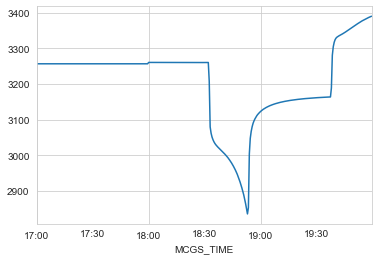

In [46]:
# Visulize data
mean_30sec.plot()

<AxesSubplot:xlabel='MCGS_TIME'>

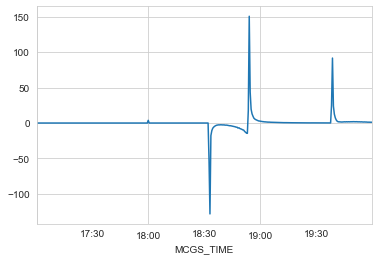

In [47]:
# Convert into stationary and check visual representation. 
roll_mean = mean_30sec.diff(periods=1).dropna()
roll_mean.plot()

In [164]:
# Check new time series for stationary
adfuller(roll_mean)[1]
# Data is stationary

4.883733815473972e-19

In [185]:
# We will use SARIMAX model with diff value 1.
model = sm.tsa.statespace.SARIMAX(mean_30sec, order = (2,1,1), enforce_invertibility=False)

In [186]:
# Fit the model and print results
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81848D+00    |proj g|=  2.02297D-02

At iterate    5    f=  3.81832D+00    |proj g|=  4.60524D-03

At iterate   10    f=  3.81797D+00    |proj g|=  1.54741D-03

At iterate   15    f=  3.81796D+00    |proj g|=  1.47207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   5.707D-06   3.818D+00
  F =   3.8179542275818146     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1374.464
Date:                Mon, 28 Feb 2022   AIC                           2756.927
Time:                        15:53:15   BIC                           2772.460
Sample:                    06-10-2021   HQIC                          2763.104
                         - 06-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0706      1.128      0.063      0.950      -2.141       2.282
ar.L2          0.1097      0.545      0.201      0.841      -0.959       1.179
ma.L1          0.4339      1.136      0.382      0.702      -1.792       2.660
sigma2       123.7931      2.053     60.305      0.000     119.770     127.817
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            140491.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             504.46   Skew:                             4.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [188]:
pred = result.get_prediction(start = "2021-06-10 17:30:00", dynamic = False)
pred_conf = pred.conf_int(alpha=0.005)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


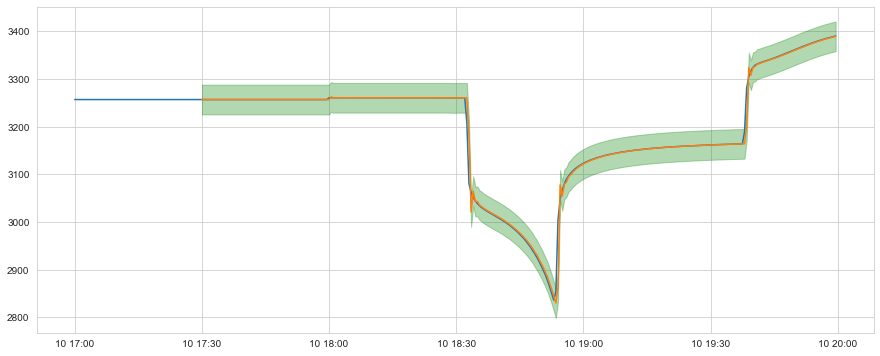

In [189]:
# Plot real vs predicted values along with confidence interval
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
plt.plot(mean_30sec, label='observed')

# Plot predicted values
plt.plot(pred.predicted_mean, label = "predicted")

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:,0],
                 pred_conf.iloc[:,1], color = "green", alpha = 0.3)



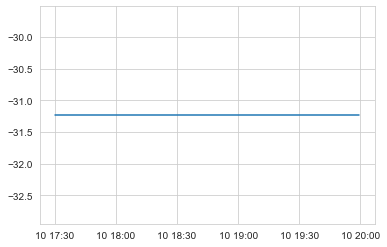

In [191]:
# plot prediction boundaries 
plt.plot(pred.predicted_mean - pred_conf.iloc[:,1], label = "predicted")
# This is the straight line. 

In [192]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

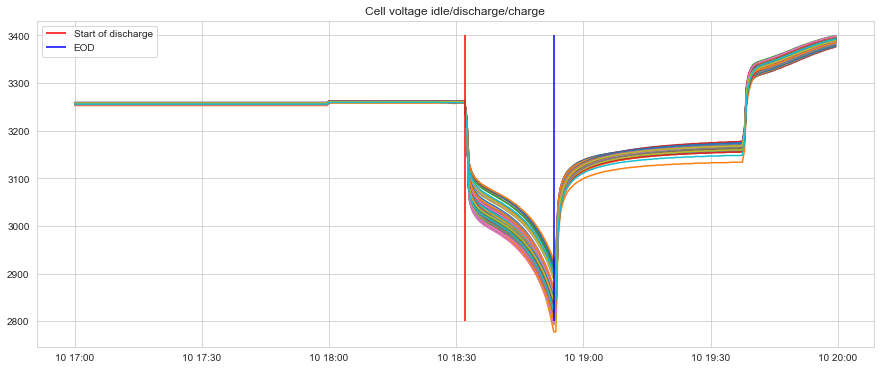

In [216]:
# Lets plot voltage distribution during time. 
fig, axs = plt.subplots(figsize = (15, 6))
plt.plot(df_30sec)
axs.set_title("Cell voltage idle/discharge/charge")
plt.vlines(x = df_30sec.index[184],ymin = 2800, ymax = 3400, color = "red", label = "Start of discharge")
plt.vlines(x = timestamp_eod,ymin = 2800, ymax = 3400, color = "blue", label = "EOD")
plt.legend()
plt.show()

<AxesSubplot:xlabel='MCGS_TIME'>

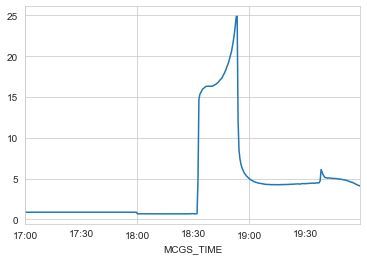

In [56]:
# Lets plot also standard deviation on sensor reading during the time.
np.std(df_30sec, axis = 1).plot()

In [258]:
sensor_list = []
for sensor in list(df_30sec.columns):
    anomaly = df_30sec["2021-06-10 17:30:00":][sensor][(df_30sec["2021-06-10 17:30:00":][sensor] < pred_conf.iloc[:,0])] 
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        sensor_list.append(sensor_name)
len(sensor_list)

240

In [ ]:
# Model gives us positive prediction 100% of the time. 


### Second model

In [105]:
# We need to check voltage distribution in different time of discharge and charge. 

Value mean : 3.26 V
Value standard deviation : 0.0007 V


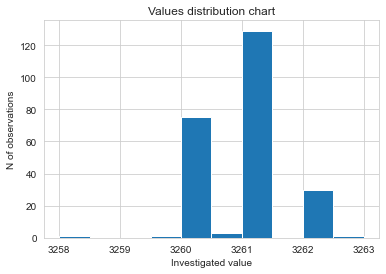

In [111]:
# Lets check voltage sensor reading distribution during different moments of time.
# idle
moment = '2021-06-10 18:00:00'
check_distribution(df_30sec, moment)

Value mean : 3.26 V
Value standard deviation : 0.0007 V


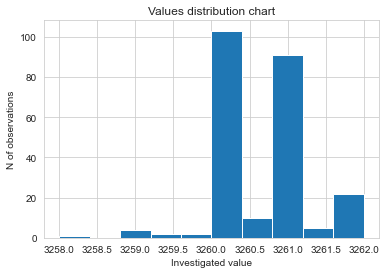

In [112]:
# Resting
moment = '2021-06-10 18:30:00'
check_distribution(df_30sec, moment)

Value mean : 3.16 V
Value standard deviation : 0.0044 V


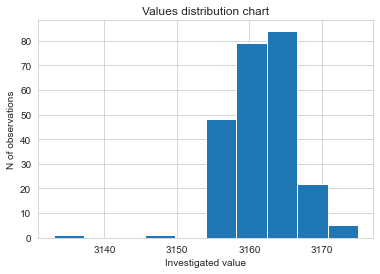

In [113]:
# Charging
moment = '2021-06-10 19:30:00'
check_distribution(df_30sec, moment)



Value mean : 3.04 V
Value standard deviation : 0.016 V


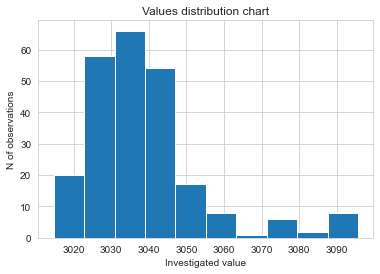

In [114]:
# Start of discharge
moment = '2021-06-10 18:35:00'
check_distribution(df_30sec, moment)


Value mean : 2.97 V
Value standard deviation : 0.0172 V


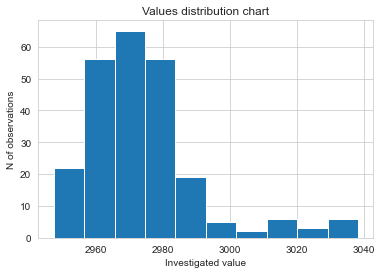

In [115]:
# Middle of discharge
moment = '2021-06-10 18:45:00'
check_distribution(df_30sec, moment)

In [66]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

Value mean : 2.84 V
Value standard deviation : 0.0249 V


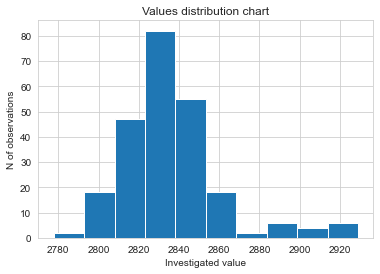

In [116]:
# End of discharge
moment = '2021-06-10 18:53:00'
check_distribution(df_30sec, moment)

In [ ]:
# As we can see voltage of cells is normally distributed

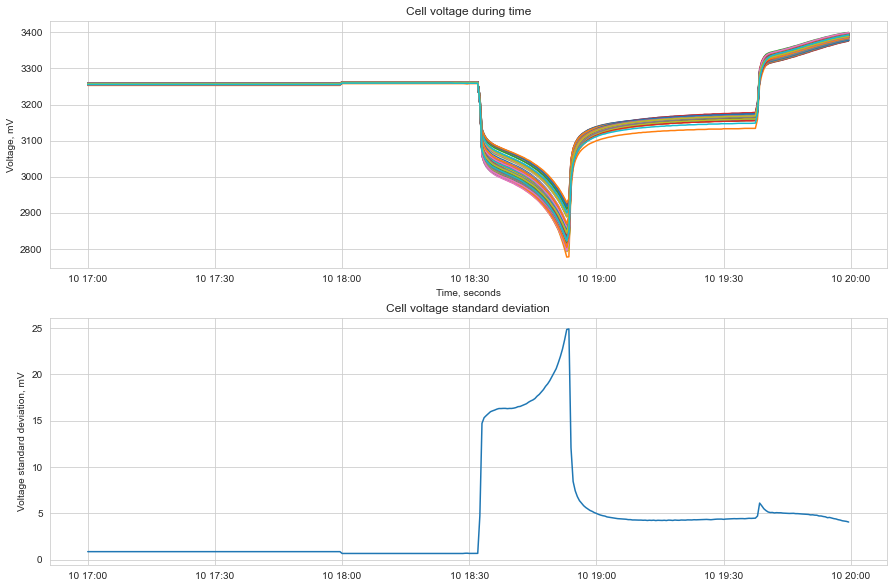

In [249]:
# Lets draw changing of standard deviation of cells during the time
fig, (top, bottom) = plt.subplots(2,1,figsize = (15, 10))
top.plot(df_30sec)
bottom.plot(np.std(df_30sec, axis = 1))
top.set_title("Cell voltage during time")
top.set_ylabel("Voltage, mV")
top.set_xlabel("Time, seconds")
bottom.set_title("Cell voltage standard deviation")
bottom.set_ylabel("Voltage standard deviation, mV")
plt.show()

As we can see, the most voltage difference batteries have at the end of discharge.

This is the moment where cells tend to fail.

##### We are focused on identifing anomalies when cell voltage exceed 3 standard deviations (probability 0.03% from Normal distribution)

##### Check sensor precision based on manufacturer website
http://www.bmser.com/?_l=en

Based on information from website:

"24 Road monomer voltage acquisition (precision <5mV) "
##### We will use 5mV as a minimum threshold during idle time and maximum will be calculated for each point of time based on idea that we should mark sensors that have performance out of range - 3 standard deviation.

### Model preparation

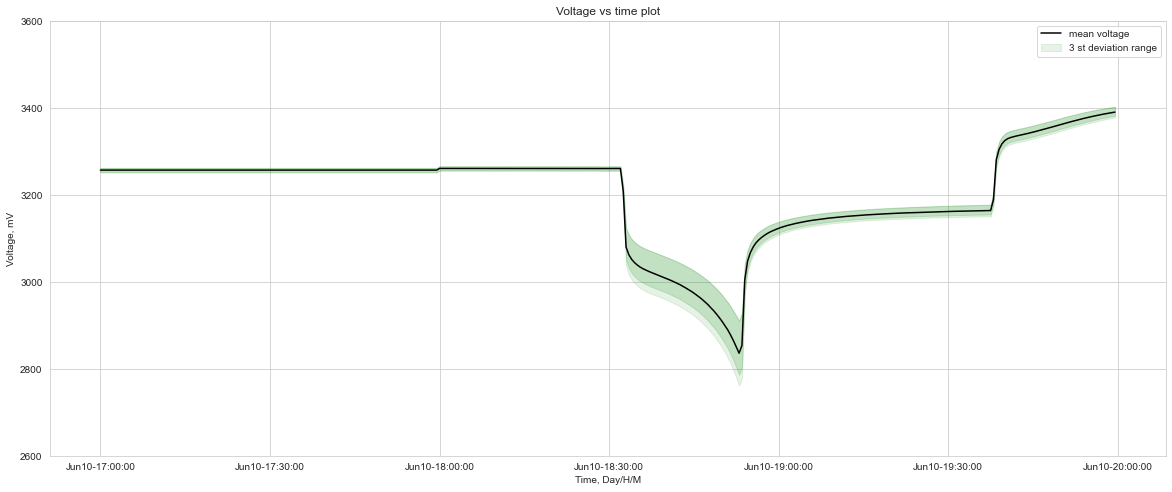

In [318]:
# Create list of thresholds for each point of time
thresholds = create_thresholds(df_30sec)

# show decision boundaries
show_boundaries(df_30sec, thresholds)


[(MCGS_TIME
2021-06-10 18:53:30    2778.333333
Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64, 'cluster_1_cellvoltage_052', 'discharge anomaly')]


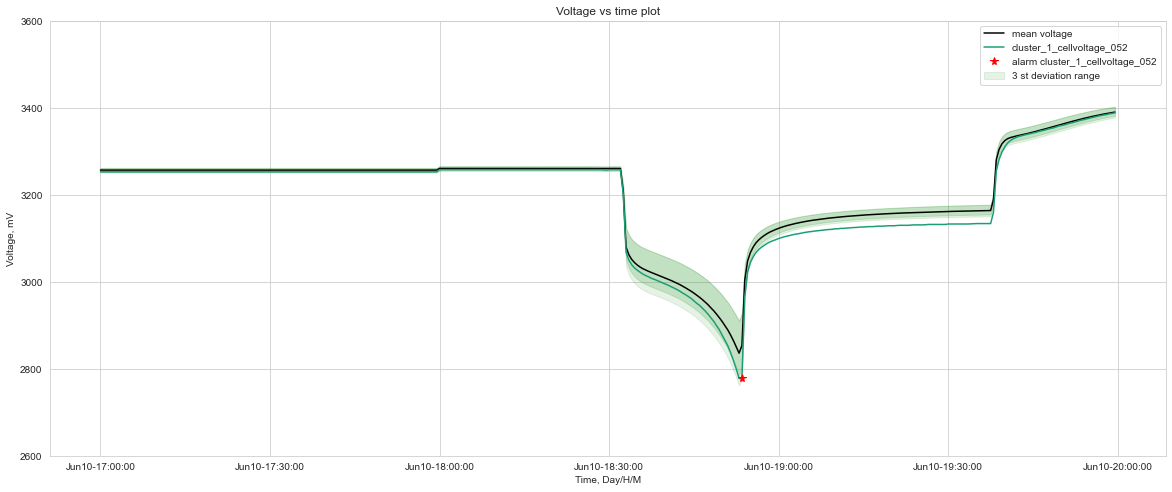

In [467]:
# Find list of faulty sensors
sensors = find_anomaly_voltage(df_30sec, thresholds, df_30sec_cur)

# Visualize sensors
show_sensors(df_30sec, sensors, thresholds)

In [457]:
sensors[0][0].keys()

DatetimeIndex(['2021-06-10 18:53:30'], dtype='datetime64[ns]', name='MCGS_TIME', freq='30S')

In [466]:
sensors[0]

(MCGS_TIME
 2021-06-10 18:53:30    2778.333333
 Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64,
 'cluster_1_cellvoltage_052',
 'discharge anomaly')

In [481]:
print_results(fault_list)

cluster N 1, discharge anomaly, cellvoltage sensor N 052
cluster N 1, discharge anomaly, cellvoltage sensor N 052
cluster N 1, discharge anomaly, cellvoltage sensor N 052
cluster N 1, discharge anomaly, cellvoltage sensor N 052


In [468]:
fault_list = []

In [480]:
fault_list = combine_faults(fault_list, sensors)

In [473]:
fault_list

[('cluster_1_cellvoltage_052',
  'discharge anomaly',
  MCGS_TIME
  2021-06-10 18:53:30    2778.333333
  Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64),
 ('cluster_1_cellvoltage_052',
  'discharge anomaly',
  MCGS_TIME
  2021-06-10 18:53:30    2778.333333
  Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64),
 ('cluster_1_cellvoltage_052',
  'discharge anomaly',
  MCGS_TIME
  2021-06-10 18:53:30    2778.333333
  Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64)]

In [479]:
def combine_faults(fault_list, sensors):
    [fault_list.append((sensor[1], sensor[2], sensor[0])) for sensor in sensors]
    return fault_list
    
def print_results(fault_list, full_report = False):
    for sensor in fault_list:
        cluster = re.search('cluster_([0-9]+)_', sensor[0]).group(1)
        sensor_type = re.search('cluster_.+_([A-Za-z]+)_', sensor[0]).group(1)
        sensor_n= re.search('cluster_.+_[A-Za-z_]+_([0-9]+)$', sensor[0]).group(1)
        type_alarm = sensor[1]
        alarm_time = sensor[2].keys()
        print(f"cluster N {cluster}, {type_alarm}, {sensor_type} sensor N {sensor_n}")
        if full_report == True:
            print(alarm_time)

        
        

In [482]:
fault_list = combine_fault(fault_list, sensors)

In [435]:
datetime.fromtimestamp(fault_list[0][2])

/var/folders/bg/b5dfn0gj1lz88k7ms283yrlm0000gn/T/ipykernel_9815/4183659769.py:1: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  datetime.fromtimestamp(fault_list[0][2])


datetime.datetime(1969, 12, 31, 16, 46, 18)

In [441]:
fault_list[0][2].keys()

DatetimeIndex(['2021-06-10 18:53:30'], dtype='datetime64[ns]', name='MCGS_TIME', freq='30S')

In [70]:


# # Make new boundaries 2 and 3 std
# df_custom["mean"] = np.mean(df_30sec, axis = 1)
# df_custom["lower_al"] = df_custom["mean"] - conf.low_voltage_alarm_n_std*np.std(df_30sec, axis = 1)
# df_custom["lower"] = df_custom["mean"] - conf.low_voltage_n_std*np.std(df_30sec, axis = 1)
# df_custom["upper_al"] = df_custom["mean"] + conf.high_voltage_n_std*np.std(df_30sec, axis = 1)
# df_custom["upper"] = df_custom["mean"] + conf.high_voltage_n_std*np.std(df_30sec, axis = 1)
# # Apply sensors precision
# df_custom["upper"][df_custom["upper"] - df_custom["mean"] < conf.sensor_v_prec] = df_custom["mean"] + conf.sensor_v_prec
# df_custom["lower"][df_custom["lower"] - df_custom["mean"] > -conf.sensor_v_prec] = df_custom["mean"] - conf.sensor_v_prec
# df_custom["upper_al"][df_custom["upper_al"] - df_custom["mean"] < conf.sensor_v_prec] = df_custom["mean"] + conf.sensor_v_prec
# df_custom["lower_al"][df_custom["lower_al"] - df_custom["mean"] > -conf.sensor_v_prec] = df_custom["mean"] - conf.sensor_v_prec


# df_30sec["cluster_1_cellvoltage_240"][(df_30sec["cluster_1_cellvoltage_240"] < df_custom["lower"]) & (result_list[0]["cluster1_current"] > 200)]

# # without status of system
# sensor_list = []
# for sensor in list(df_30sec.columns):
#     anomaly = df_30sec[sensor][(df_30sec[sensor] < df_custom["lower"])] 
#     if len(anomaly) > 0:
#         sensor_name = anomaly.name
#         sensor_list.append(sensor_name)
# print(sensor_list)

# # Add status of system
# sensor_list = []
# for sensor in list(df_30sec.columns):
#     anomaly = df_30sec[sensor][(df_30sec[sensor] < df_custom["lower"]) & (result_list[0]["cluster1_current"] >200)] 
#     if len(anomaly) > 0:
#         sensor_name = anomaly.name
#         stage = "discharge anomaly"
#         sensor_list.append((anomaly, sensor_name, stage))
# print(sensor_list)

In [ ]:
# Temperature monitoring

## Temperature distribution

In [327]:
df_30sec_temp = result_list[0][temperatrue_columns]

Value mean : 0.23 V
Value standard deviation : 0.0093 V


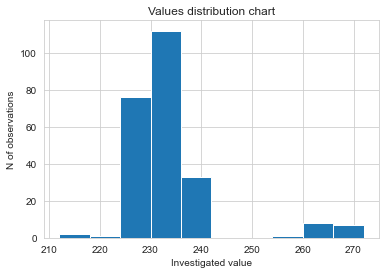

In [329]:
# Explore data distribution
# Idle
#df_30sec_temp.loc["2021-06-10 17:40:00",:].hist()
moment = '2021-06-10 18:53:00'
check_distribution(df_30sec_temp, moment)

Value mean : 17.39 C
Value standard deviation : 1.6194 C


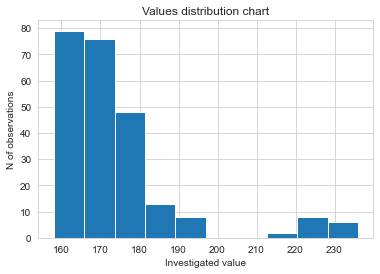

In [332]:
# Lets check voltage sensor reading distribution during different moments of time.
# idle
moment = '2021-06-10 18:00:00'
check_distribution(df_30sec_temp, moment, "temp")

Value mean : 17.4 C
Value standard deviation : 1.5256 C


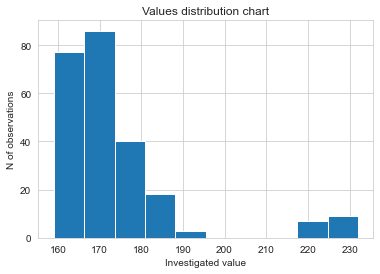

In [333]:
# Resting
moment = '2021-06-10 18:30:00'
check_distribution(df_30sec_temp, moment, "temp")

Value mean : 25.33 C
Value standard deviation : 0.706 C


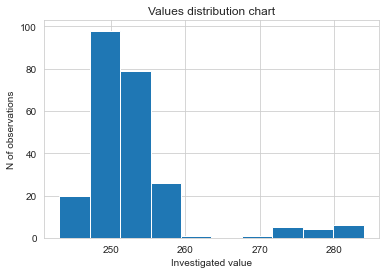

In [335]:
# Charging
moment = '2021-06-10 19:30:00'
check_distribution(df_30sec_temp, moment, "temp")


Value mean : 17.62 C
Value standard deviation : 1.367 C


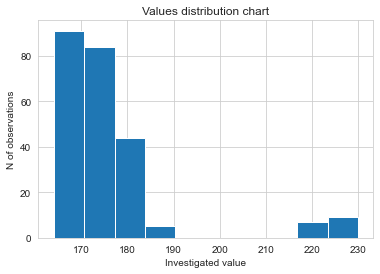

In [336]:
# Start of discharge
moment = '2021-06-10 18:35:00'
check_distribution(df_30sec_temp, moment, "temp")


Value mean : 20.09 C
Value standard deviation : 1.16 C


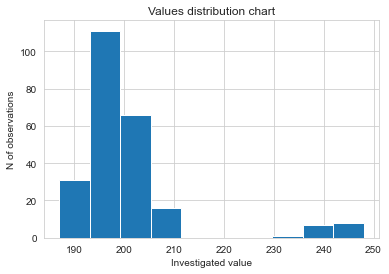

In [337]:
# Middle of discharge
moment = '2021-06-10 18:45:00'
check_distribution(df_30sec_temp, moment, "temp")


In [338]:
# Lets find end of discharge point
timestamp_eod = [key for key, value in df_30sec.min(axis=1).items() if value == df_30sec.min(axis=1).min() ]
timestamp_eod

[Timestamp('2021-06-10 18:53:00', freq='30S')]

Value mean : 23.33 C
Value standard deviation : 0.9309 C


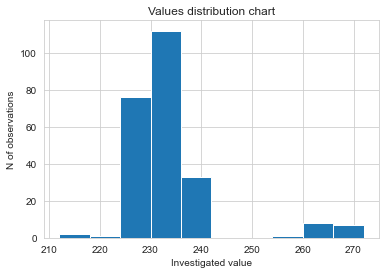

In [340]:
# End of discharge
moment = '2021-06-10 18:53:00'
check_distribution(df_30sec_temp, moment, "temp")


In [ ]:
# We can clearly see "hot regions" that probably formed due to cooled air distribution
# Batteries recommended temperature should be within 10-40 degrees range. 
# Lets define 

In [489]:
thresholds_temp = create_thresholds(df_30sec_temp, std = False)

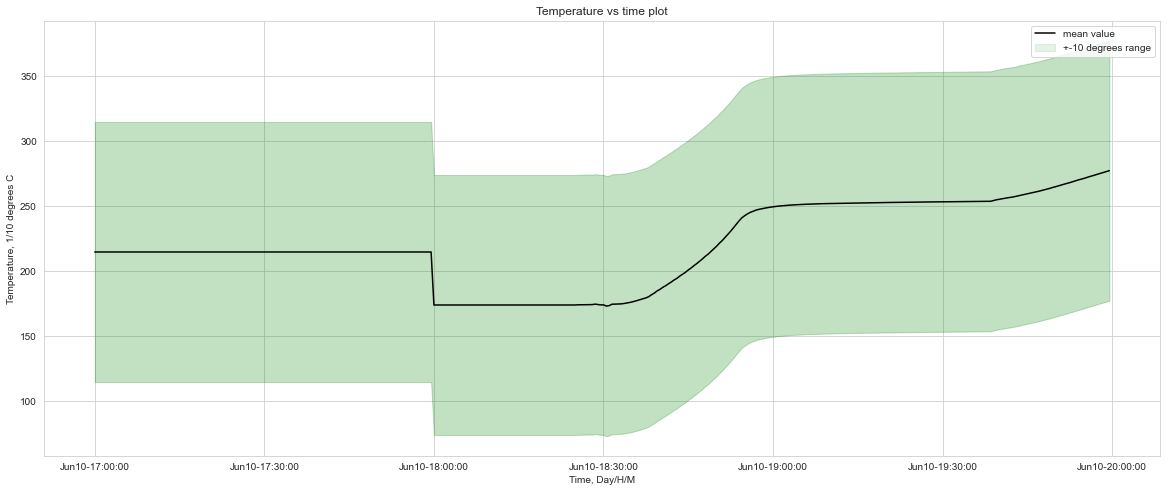

In [490]:
show_boundaries(df_30sec_temp, thresholds_temp, False)

In [491]:
sensors = find_anomaly_voltage(df_30sec_temp, df_temp, df_30sec_cur, False)

[]


In [ ]:
# # Add status of system
# sensor_list = []
# for sensor in list(df_temperatures.columns):
#     anomaly = df_temperatures[sensor][(df_temp["mean"] > conf.high_mean_temperature_alarm) | 
#                                       (df_temp["mean"] < conf.low_mean_temperature_alarm) |
#                                       (df_temperatures[sensor] < df_temp["lower"]) | 
#                                       (df_temperatures[sensor] > df_temp["upper"])]
#     if len(anomaly) > 0:
#         sensor_name = anomaly.name
#         stage = "temperature anomaly"
#         sensor_list.append((anomaly, sensor_name, stage))
# print(sensor_list)



In [ ]:

for sensor in list(df_30sec.columns):
    if df_30sec[sensor][df_30sec[sensor] < df_custom["lower"]].sum() > 0:
        print(sensor)


In [ ]:
# Plot data predictions boundaries
fig, axs = plt.subplots(figsize = (15, 10))

# Plot observed values
plt.plot(df_custom["mean"], label='mean voltage')
[plt.plot(df_30sec[sensor[1]]) for sensor in sensor_list]


plt.fill_between(df_custom.index, 
                 df_custom["lower"],
                 df_custom["upper"], color = "green", alpha = 0.1)

# Plot the range for confidence intervals
plt.fill_between(df_custom.index, 
                 df_custom["lower_al"],
                 df_custom["upper_al"], color = "green", alpha = 0.2)

In [ ]:
(df_30sec.loc[:,"Cluster_1_CellVoltage_052"] < df_custom["lower"]).sum()

In [ ]:
np.mean(df_30sec.loc['2021-06-10 18:42:00',:])

In [ ]:
np.std(df_30sec.loc['2021-06-10 18:42:00',:])

In [ ]:
np.mean(df_30sec.loc['2021-06-10 18:42:00',:]) - 2* np.std(df_30sec.loc['2021-06-10 18:42:00',:])

In [ ]:
# Plot real vs predicted values along with confidence interval
fig, axs = plt.subplots(figsize = (15, 6))

# Plot observed values
#plt.plot(mean_30sec, label='observed')

# Plot predicted values
plt.plot(mean_30sec, label = "predicted")

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index, 
                 pred_conf.iloc[:,0],
                 pred_conf.iloc[:,1], color = "green", alpha = 0.3)

In [ ]:
final_df.shape

fig, axs = plt.subplots(1,1, figsize = (14,4))
final_df.plot(ax = axs)

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (14,4))
(np.mean(final_df, axis = 1) - final_df.min(axis = 1)).plot(ax = axs)

In [ ]:
# make mean df

In [ ]:
len(final_df.columns)

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (24,8))
np.mean(final_df, axis = 1).plot(ax = axs)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model0 = ARIMA(np.mean(df2, axis = 1), dates=None,order=(2,1,0))

In [ ]:
result_arima = model0.fit()

In [ ]:
xz = result_arima.predict()

In [ ]:
xz.plot()

In [ ]:
from statsmodels.tsa.statespace import SARIMAX

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model0 = ARIMA(np.mean(final_df, axis = 1), dates=None,order=(2,1,0))

model1 = model0.fit(disp=1)

decomposition = seasonal_decompose(np.array(np.mean(final_df, axis = 1)).reshape(len(np.mean(final_df, axis = 1)),),freq=1)
### insert your data seasonality in 'freq'

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
final_df.plot()

In [ ]:
# Full data tests

In [79]:
raw_folder2 = "raw2/"
result_list2 = data_preprocess(raw_folder2)

DatetimeIndex(['2021-06-10 10:29:30', '2021-06-10 10:30:00',
               '2021-06-10 10:30:30', '2021-06-10 10:31:00',
               '2021-06-10 10:31:30', '2021-06-10 10:32:00',
               '2021-06-10 10:32:30', '2021-06-10 10:33:00',
               '2021-06-10 10:33:30', '2021-06-10 10:34:00',
               ...
               '2021-06-11 10:27:00', '2021-06-11 10:27:30',
               '2021-06-11 10:28:00', '2021-06-11 10:28:30',
               '2021-06-11 10:29:00', '2021-06-11 10:29:30',
               '2021-06-11 10:30:00', '2021-06-11 10:30:30',
               '2021-06-11 10:31:00', '2021-06-11 10:31:30'],
              dtype='datetime64[ns]', name='MCGS_TIME', length=2885, freq='30S')
DatetimeIndex(['2021-06-10 10:29:30', '2021-06-10 10:30:00',
               '2021-06-10 10:30:30', '2021-06-10 10:31:00',
               '2021-06-10 10:31:30', '2021-06-10 10:32:00',
               '2021-06-10 10:32:30', '2021-06-10 10:33:00',
               '2021-06-10 10:33:30', '2021-0

In [80]:
result_list2[0]

,cluster_1_cellvoltage_001,cluster_1_cellvoltage_002,cluster_1_cellvoltage_003,cluster_1_cellvoltage_004,cluster_1_cellvoltage_005,cluster_1_cellvoltage_006,cluster_1_cellvoltage_007,cluster_1_cellvoltage_008,cluster_1_cellvoltage_009,cluster_1_cellvoltage_010,...,cluster_1_temperature_232,cluster_1_temperature_233,cluster_1_temperature_234,cluster_1_temperature_235,cluster_1_temperature_236,cluster_1_temperature_237,cluster_1_temperature_238,cluster_1_temperature_239,cluster_1_temperature_240,cluster1_current
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2021-06-10 10:29:30,3297.000000,3298.0,3297.666667,3297.333333,3297.0,3297.000000,3297.0,3297.0,3297.0,3297.333333,...,244.0,246.0,244.0,239.0,240.0,238.0,239.0,240.0,243.0,0.0
2021-06-10 10:30:00,3297.000000,3298.0,3297.666667,3297.666667,3297.0,3297.333333,3297.0,3297.0,3297.0,3297.000000,...,244.0,246.0,244.0,239.0,240.0,238.0,239.0,240.0,243.0,0.0
2021-06-10 10:30:30,3297.000000,3298.0,3298.000000,3298.000000,3297.0,3297.000000,3297.0,3297.0,3297.0,3297.000000,...,244.0,246.0,244.0,239.0,240.0,238.0,239.0,240.0,243.0,0.0
2021-06-10 10:31:00,3297.000000,3298.0,3298.000000,3298.000000,3297.0,3297.000000,3297.0,3297.0,3297.0,3297.000000,...,244.0,246.0,244.0,239.0,240.0,238.0,239.0,240.0,243.0,0.0
2021-06-10 10:31:30,3297.000000,3298.0,3298.000000,3298.000000,3297.0,3297.000000,3297.0,3297.0,3297.0,3297.000000,...,244.0,246.0,244.0,239.0,240.0,238.0,239.0,240.0,243.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-11 10:29:30,3108.333333,3083.0,3080.000000,3075.000000,3077.0,3117.000000,3112.0,3121.0,3118.0,3112.000000,...,292.0,285.0,289.0,282.0,269.0,256.0,244.0,253.0,266.0,0.0
2021-06-11 10:30:00,3108.666667,3083.0,3080.000000,3075.000000,3077.0,3117.000000,3112.0,3121.0,3118.0,3112.000000,...,291.0,284.0,288.0,281.0,269.0,255.0,244.0,253.0,266.0,0.0
2021-06-11 10:30:30,3109.000000,3083.0,3080.000000,3075.000000,3077.0,3117.000000,3112.0,3121.0,3118.0,3112.000000,...,291.0,284.0,287.0,281.0,268.0,255.0,243.0,252.0,265.0,0.0


In [81]:
df_30sec = result_list2[0][voltage_columns]

In [82]:
df_custom = pd.DataFrame()

In [83]:
np.std(df_30sec, axis = 1).value_counts()

0.875238     324
0.437718      83
1.143703      77
0.680061      50
0.478423      16
            ... 
9.025775       1
8.936763       1
8.841589       1
8.768518       1
15.573480      1
Length: 2323, dtype: int64

In [280]:
#df_30sec["2021-06-10 11:28:30"]

# Make new boundaries 2 and 3 std
df_custom["mean"] = np.mean(df_30sec, axis = 1)
df_custom["lower_al"] = df_custom["mean"] - conf.low_voltage_alarm_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
df_custom["lower"] = df_custom["mean"] - conf.low_voltage_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
df_custom["upper_al"] = df_custom["mean"] + conf.high_voltage_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
df_custom["upper"] = df_custom["mean"] + conf.high_voltage_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)

In [282]:
# Apply sensors precision
df_custom["upper"][df_custom["upper"] - df_custom["mean"] < conf.sensor_v_prec] = df_custom["mean"] + conf.sensor_v_prec
df_custom["lower"][df_custom["lower"] - df_custom["mean"] > -conf.sensor_v_prec] = df_custom["mean"] - conf.sensor_v_prec
df_custom["upper_al"][df_custom["upper_al"] - df_custom["mean"] < conf.sensor_v_prec] = df_custom["mean"] + conf.sensor_v_prec
df_custom["lower_al"][df_custom["lower_al"] - df_custom["mean"] > -conf.sensor_v_prec] = df_custom["mean"] - conf.sensor_v_prec


In [283]:
df_custom

,mean,lower_al,lower,upper_al,upper
MCGS_TIME,,,,,
2021-06-10 17:00:00,3256.975000,3251.975000,3251.975000,3261.975000,3261.975000
2021-06-10 17:00:30,3256.975000,3251.975000,3251.975000,3261.975000,3261.975000
2021-06-10 17:01:00,3256.975000,3251.975000,3251.975000,3261.975000,3261.975000
2021-06-10 17:01:30,3256.975000,3251.975000,3251.975000,3261.975000,3261.975000
2021-06-10 17:02:00,3256.975000,3251.975000,3251.975000,3261.975000,3261.975000
...,...,...,...,...,...
2021-06-10 19:57:30,3385.766667,3377.200108,3372.916829,3398.616505,3398.616505
2021-06-10 19:58:00,3386.925000,3378.507882,3374.299323,3399.550677,3399.550677
2021-06-10 19:58:30,3388.094444,3379.740832,3375.564026,3400.624863,3400.624863


In [87]:
df_custom["mean"]["2021-06-10 10:29:30":"2021-06-10 10:39:30"]
df_30sec.loc["2021-06-10 11:29:00"].value_counts()


3297.000000    156
3298.000000     62
2198.000000     13
3296.000000      4
2198.666667      3
3297.333333      1
3297.666667      1
Name: 2021-06-10 11:29:00, dtype: int64

In [88]:
from datetime import timedelta

(df_custom.index[-1] - df_custom.index[0]).days*24//12


#df_custom.index


2

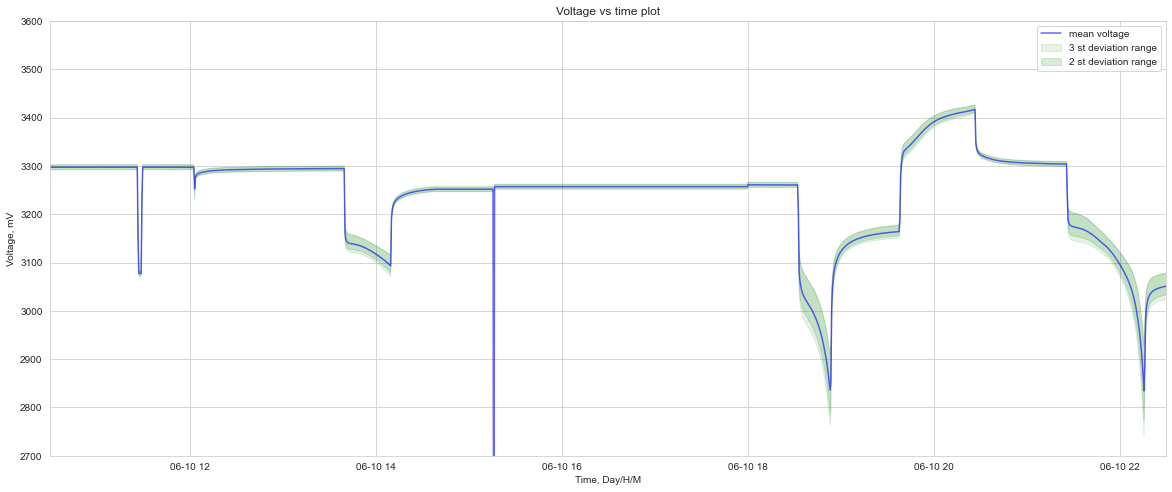

In [89]:
sns.set_style("whitegrid")
# Plot data predictions boundaries
fig, axs = plt.subplots(figsize = (20, 8))

# Plot observed values
plt.plot(df_custom["mean"], label='mean voltage', color = "blue", alpha = 0.6)

plt.fill_between(df_custom.index, 
                 df_custom["lower"],
                 df_custom["upper"], color = "green", alpha = 0.10, label = "3 st deviation range")

# Plot the range for confidence intervals
plt.fill_between(df_custom.index, 
                 df_custom["lower_al"],
                 df_custom["upper_al"], color = "green", alpha = 0.15, label = "2 st deviation range")
axs.set_title("Voltage vs time plot")
axs.set_xlabel("Time, Day/H/M")
axs.set_ylabel("Voltage, mV")
axs.legend()
plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
plt.ylim(2700,3600)
plt.show()




In [ ]:
df_30sec["cluster_1_cellvoltage_240"][(df_30sec["cluster_1_cellvoltage_240"] < df_custom["lower"]) & (result_list[0]["cluster1_current"] > 200)]



In [ ]:
result_list[0]["cluster1_current"]["2021-06-10 18:53:00"]

In [ ]:
df_30sec["cluster_1_cellvoltage_240"]

In [284]:
# without status of system
sensor_list = []
for sensor in list(df_30sec.columns):
    anomaly = df_30sec[sensor][(df_30sec[sensor] < df_custom["lower"])] 
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        sensor_list.append(sensor_name)
print(sensor_list)

['cluster_1_cellvoltage_023', 'cluster_1_cellvoltage_024', 'cluster_1_cellvoltage_025', 'cluster_1_cellvoltage_026', 'cluster_1_cellvoltage_031', 'cluster_1_cellvoltage_032', 'cluster_1_cellvoltage_052', 'cluster_1_cellvoltage_240']


In [316]:
# # Make new boundaries 2 and 3 std
# df_custom = pd.DataFrame()
# df_custom["mean"] = np.mean(df_30sec, axis = 1)
# df_custom["lower_al"] = df_custom["mean"] - conf.low_voltage_alarm_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
# df_custom["lower"] = df_custom["mean"] - conf.low_voltage_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
# df_custom["upper_al"] = df_custom["mean"] + conf.high_voltage_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
# df_custom["upper"] = df_custom["mean"] + conf.high_voltage_n_std*np.std(df_30sec[df_30sec > 2300], axis = 1)
# # Apply sensors precision
# df_custom["upper"][df_custom["upper"] - df_custom["mean"] < conf.sensor_v_prec] = df_custom["mean"] + conf.sensor_v_prec
# df_custom["lower"][df_custom["lower"] - df_custom["mean"] > -conf.sensor_v_prec] = df_custom["mean"] - conf.sensor_v_prec
# df_custom["upper_al"][df_custom["upper_al"] - df_custom["mean"] < conf.sensor_v_prec] = df_custom["mean"] + conf.sensor_v_prec
# df_custom["lower_al"][df_custom["lower_al"] - df_custom["mean"] > -conf.sensor_v_prec] = df_custom["mean"] - conf.sensor_v_prec



def create_thresholds(df_voltage):
    # Calculate mean value and high/low voltage alarms, thresholds.
    df_threshold = pd.DataFrame()
    df_threshold["mean"] = np.mean(df_voltage, axis = 1)
    df_threshold["lower_al"] = df_threshold["mean"] - conf.low_voltage_alarm_n_std*np.std(df_voltage[df_voltage > 2300], axis = 1)
    df_threshold["lower"] = df_threshold["mean"] - conf.low_voltage_n_std*np.std(df_voltage[df_voltage > 2300], axis = 1)
    df_threshold["upper_al"] = df_threshold["mean"] + conf.high_voltage_n_std*np.std(df_voltage[df_voltage > 2300], axis = 1)
    df_threshold["upper"] = df_threshold["mean"] + conf.high_voltage_n_std*np.std(df_voltage[df_voltage > 2300], axis = 1)
    # Apply sensors precision
    df_threshold["upper"][df_threshold["upper"] - df_threshold["mean"] < conf.sensor_v_prec] = df_threshold["mean"] + conf.sensor_v_prec
    df_threshold["lower"][df_threshold["lower"] - df_threshold["mean"] > -conf.sensor_v_prec] = df_threshold["mean"] - conf.sensor_v_prec
    df_threshold["upper_al"][df_threshold["upper_al"] - df_threshold["mean"] < conf.sensor_v_prec] = df_threshold["mean"] + conf.sensor_v_prec
    df_threshold["lower_al"][df_threshold["lower_al"] - df_threshold["mean"] > -conf.sensor_v_prec] = df_threshold["mean"] - conf.sensor_v_prec
    return df_threshold


def find_anomaly_voltage(dataframe, thresholds, current_df):
    # Based on thresholds identify anomalies. 
    sensor_list = []
    for sensor in list(dataframe.columns):
        anomaly = dataframe[sensor][(dataframe[sensor] < thresholds["lower"]) & (current_df["cluster1_current"] >200)] 
        if len(anomaly) > 0:
            sensor_name = anomaly.name
            stage = "discharge anomaly"
            sensor_list.append((anomaly, sensor_name, stage))
    print(sensor_list)
    return sensor_list

def show_boundaries(dataframe,  thresholds):
    fig, axs = plt.subplots(figsize = (20, 8))
    # Plot data predictions boundaries
    plt.plot(thresholds["mean"], label='mean voltage', c = "black")
    plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")

    # Plot the range for confidence intervals
    plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.15)
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)
    plt.ylim(2600,3600)
    #plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    axs.set_title("Voltage vs time plot")
    axs.set_xlabel("Time, Day/H/M")
    axs.set_ylabel("Voltage, mV")

    plt.legend()
    plt.show()
    
    
def show_sensors(dataframe, faulty_sensors, thresholds):
    fig, axs = plt.subplots(figsize = (20, 8))
    # Plot data predictions boundaries
    plt.plot(thresholds["mean"], label='mean voltage', c = "black")
    [plt.plot(dataframe[sensor[1]], label = sensor[1], color = cmap(number)) for number, sensor in enumerate(faulty_sensors)]
    [plt.plot(sensor[0], label = "alarm " + sensor[1], c = "red", marker = markers[number],markersize = 8, linestyle="") for number, sensor in enumerate(faulty_sensors)]

    plt.fill_between(thresholds.index, 
                     thresholds["lower"],
                     thresholds["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")

    # Plot the range for confidence intervals
    plt.fill_between(thresholds.index, 
                     thresholds["lower_al"],
                     thresholds["upper_al"], color = "green", alpha = 0.15)
    date_form = DateFormatter("%b%d-%H:%M:%S")
    axs.xaxis.set_major_formatter(date_form)
    plt.ylim(2600,3600)
    #plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
    axs.set_title("Voltage vs time plot")
    axs.set_xlabel("Time, Day/H/M")
    axs.set_ylabel("Voltage, mV")

    plt.legend()
    plt.show()
    

    

    

In [293]:
thresholds = create_thresholds(df_30sec)
sensors = find_anomaly_voltage(df_30sec, thresholds, df_30sec_cur)
show_boundaries(df_30sec, thresholds)
show_sensors(df_30sec, sensors, thresholds)


In [296]:
sensors = find_anomaly_voltage(df_30sec, thresholds, df_30sec_cur)

[(MCGS_TIME
2021-06-10 18:53:30    2778.333333
Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64, 'cluster_1_cellvoltage_052', 'discharge anomaly')]


In [307]:
sensors[0][1]

'cluster_1_cellvoltage_052'

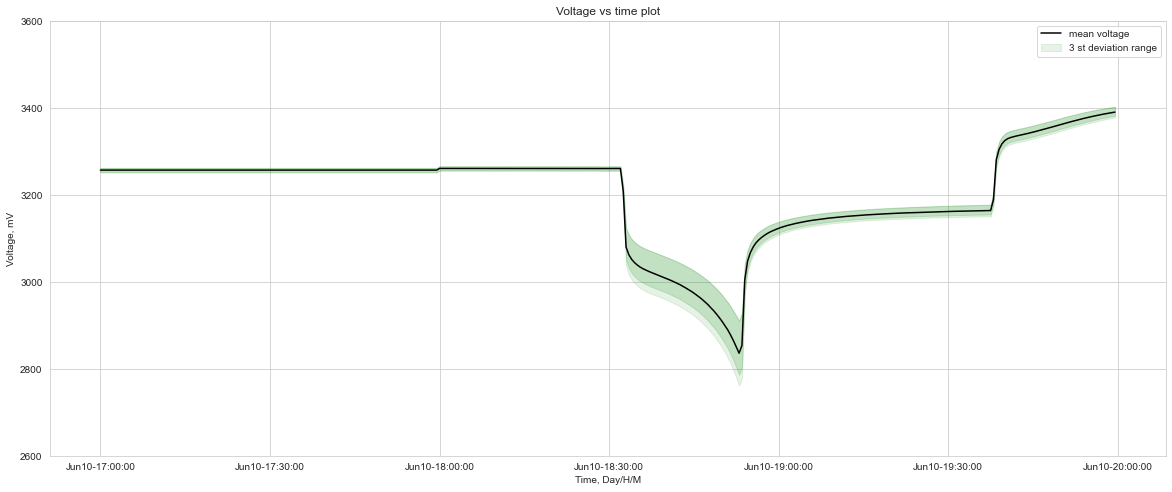

In [317]:
show_boundaries(df_30sec, thresholds)

In [ ]:
show_sensors(df_30sec, sensors, thresholds)

In [285]:
# Add status of system
sensor_list = []
for sensor in list(df_30sec.columns):
    anomaly = df_30sec[sensor][(df_30sec[sensor] < df_custom["lower"]) & (result_list[0]["cluster1_current"] >200)] 
    if len(anomaly) > 0:
        sensor_name = anomaly.name
        stage = "discharge anomaly"
        sensor_list.append((anomaly, sensor_name, stage))
print(sensor_list)

[(MCGS_TIME
2021-06-10 18:53:30    2778.333333
Freq: 30S, Name: cluster_1_cellvoltage_052, dtype: float64, 'cluster_1_cellvoltage_052', 'discharge anomaly')]


/var/folders/bg/b5dfn0gj1lz88k7ms283yrlm0000gn/T/ipykernel_9815/563221200.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


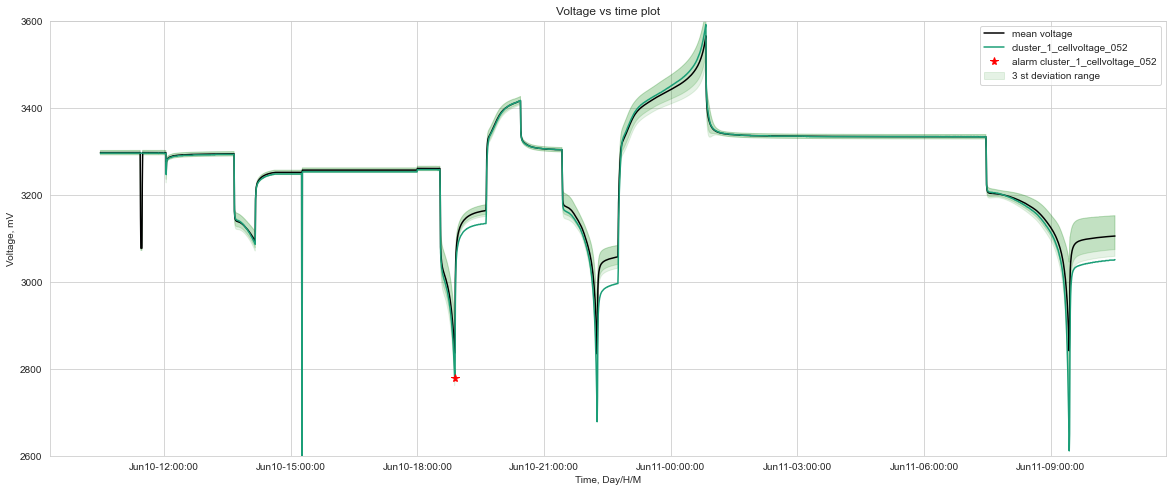

In [98]:
# Plot data predictions boundaries
fig, axs = plt.subplots(figsize = (20, 8))


# Plot observed values
plt.plot(df_custom["mean"], label='mean voltage', c = "black")
[plt.plot(df_30sec[sensor[1]], label = sensor[1], color = cmap(number)) for number, sensor in enumerate(sensor_list)]
[plt.plot(sensor[0], label = "alarm " + sensor[1], c = "red", marker = markers[number],markersize = 8, linestyle="") for number, sensor in enumerate(sensor_list)]

plt.fill_between(df_custom.index, 
                 df_custom["lower"],
                 df_custom["upper"], color = "green", alpha = 0.1, label = "3 st deviation range")

# Plot the range for confidence intervals
plt.fill_between(df_custom.index, 
                 df_custom["lower_al"],
                 df_custom["upper_al"], color = "green", alpha = 0.15)

date_form = DateFormatter("%b%d-%H:%M:%S")
axs.xaxis.set_major_formatter(date_form)
plt.ylim(2600,3600)
#plt.xlim(df_custom.index[0], df_custom.index[0] + timedelta(hours = 12))
axs.set_title("Voltage vs time plot")
axs.set_xlabel("Time, Day/H/M")
axs.set_ylabel("Voltage, mV")

plt.legend()
fig.show()

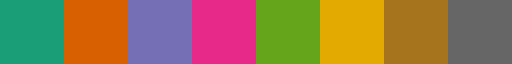

In [96]:
cmap(4)
plt.get_cmap(cmap)

In [97]:
import matplotlib.colors as mcolors

In [ ]:
data_train_dir = 'train/'
data_train_clean = 'train_cleaned/'
new_dir = 'data/'
test_dir = "test/"
data_test_after = "after/"
raw_folder = "raw/"

In [ ]:
# Define path
train = os.path.join(new_dir, data_train_dir)
train_clean = os.path.join(new_dir, data_train_clean)

test_folder = os.path.join(new_dir, test_dir)
test_folder_after = os.path.join(test_folder, data_test_after)


In [ ]:
test_folder

In [ ]:
# Create directories
os.mkdir(new_dir)
os.mkdir(test_folder)

os.mkdir(train)
os.mkdir(train_clean)

os.mkdir(test_folder_after)


In [ ]:
# Unpack data
with zipfile.ZipFile(raw_folder + 'train.zip', 'r') as zip_train:
    zip_train.extractall(new_dir)
with zipfile.ZipFile(raw_folder + 'train_cleaned.zip', 'r') as zip_train_clean:
    zip_train_clean.extractall(new_dir)
with zipfile.ZipFile(raw_folder + 'test.zip', 'r') as zip_test:
    zip_test.extractall(new_dir)


In [ ]:
# Train set
imgs_train = sorted([file for file in os.listdir(train) if file.endswith('.png')])
imgs_train_clean = sorted([file for file in os.listdir(train_clean) if file.endswith('.png')])

# Test set
imgs_test = sorted([file for file in os.listdir(test_folder) if file.endswith('.png')])


In [ ]:
os.listdir(train)

In [ ]:
print("Train set:")
print('There are', len(imgs_train), 'normal images, image name example,',os.listdir(train)[0])
print('There are', len(imgs_train_clean), 'pneumonia images, image name example,',os.listdir(train_clean)[0])
print("Test set:")
print('There are', len(imgs_test), 'normal images, image name example,',os.listdir(test_folder)[0])


In [ ]:
train_img_number = len(imgs_train)
val_img_number = len(imgs_train_clean)
test_img_number = len(imgs_test)

In [ ]:
# Create data without aug
def process_data_no_aug(img_size):
    # Data generation objects
    # get all the data in the directory split/train, and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train, 
        target_size=img_size, batch_size= train_img_number)

    # get all the data in the directory split/validation, and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_clean, 
        target_size=img_size, batch_size = val_img_number)

    # get all the data in the directory split/test, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=img_size, batch_size = test_img_number) 

    
    
    return train_generator, val_generator, test_generator

In [ ]:
test_folder

In [ ]:
image_size = (540,420)
train_generator, val_generator, test_generator = process_data_no_aug(image_size)



In [ ]:
# plot 8 random photos of normal and pneumonia X-ray
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for x in range(0,4):
        i = np.random.randint(0,len(imgs_train))
        axes[x][0].imshow(imgs_train[i])
        axes[x][1].imshow(imgs_train_clean[i])

#         if train_labels[i][0] == 0:
#             axes[x][y].set_title('Normal')
#         else:
#             axes[x][y].set_title('Pneumonia')

Make new split directory

### Setting up help functions:

##### Results visualization:

In [ ]:
# Plots of losses.
def visualize_training_results(results):
    # Create figures
    fig, (left, right) = plt.subplots(1,2, figsize = (16,6))
    history = results.history
    # Loss functions plot
    left.plot(history['val_loss'], label = "val loss")
    left.plot(history['loss'], label = "loss")
    left.set_title('Loss')
    left.set_xlabel('Epochs')
    left.set_ylabel('Loss')
    left.legend()
    # Accuracy plot
    right.plot(history['val_accuracy'], label = "val accuracy")
    right.plot(history['accuracy'], label = "accuracy")
    right.set_title('Accuracy')
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    right.legend()
    path = "./img/Loss_"+model_name+".png"
    plt.savefig(path)
    plt.show()
    
    

In [ ]:
# Create data with aug
def process_data_aug(img_size, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=20,   
                                       zoom_range=0.2,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2,
                                       vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_datagen.flow_from_directory(
      directory=train_folder, 
      target_size=img_size, 
      batch_size=92, 
      class_mode='binary',
      shuffle = True)

    val_generator = test_val_datagen.flow_from_directory(
      directory=val_folder, 
      target_size=img_size, 
      batch_size=32, 
      class_mode='binary',
      shuffle = True)
    
    test_generator = test_val_datagen.flow_from_directory(
        test_folder, 
        target_size=img_size, 
        batch_size = test_img_number)  
    
    
    return train_generator, val_generator, test_generator



In [ ]:
# Create data without aug
def process_data_no_aug(img_size):
    # Data generation objects
    # get all the data in the directory split/train, and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=img_size, batch_size= train_img_number)

    # get all the data in the directory split/validation, and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=img_size, batch_size = val_img_number)

    # get all the data in the directory split/test, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=img_size, batch_size = test_img_number) 

    
    
    return train_generator, val_generator, test_generator



In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    path = "./img/CM_"+model_name+".png"
    plt.savefig(path)
    plt.show()

In [ ]:
# Plot results:
# - Loss, accuracy for val and train sets during training. 
# - Confusion matrix for test results. 

def plot_results(results, model, test_images,  test_y =None, threshold = 0.5,):
    visualize_training_results(results)
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    accuracy = accuracy_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    print('Test Accuracy = %.2f' % accuracy)# Combined plotting. 

    print('Recall = %.2f' % recall)
    confusion_mtx = confusion_matrix(test_y, predictions)
    cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

In [ ]:
# Create dataframe with finall results.
result_columns = ["Model name","Image size","Parameters","Train time","Train accuracy", "Validation accuracy", "Test accuracy", "Test Recall"]
results_df = pd.DataFrame(columns = result_columns)

                  
# Results:
def make_results(model_selection, image_size, train_time,model_name, results, model, test_images, test_y, threshold = 0.5):
    predictions = model.predict(test_images)
    predictions = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_y, predictions),4)
    test_recall = round(recall_score(test_y, predictions),4)
    train_accuracy = round(results.history["accuracy"][-1],4)
    val_accuracy = round(results.history["val_accuracy"][-1],4)
    train_epoch = len(results.epoch)
    N_of_params = int(np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables]) + np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_variables]))
    line = pd.DataFrame(np.array([[model_name, image_size, N_of_params,
                               train_time, train_accuracy, val_accuracy,
                               test_accuracy, test_recall]]), columns = result_columns)
    model_selection = pd.concat([model_selection,line], axis = 0)
    return model_selection

### Use a densely connected network as a baseline

##### Prepare images

##### 64x64 images without data augmentation

In [ ]:
image_size = (64,64)
train_generator, val_generator, test_generator = process_data_no_aug(image_size)

In [ ]:
# Prepare images and lables.
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [ ]:
# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

##### Visualize data

In [ ]:
# plot 16 random photos of normal and pneumonia X-ray
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

for x in range(0,4):
    for y in range(0, 4):
        i = np.random.randint(0,len(train_images))
        axes[x][y].imshow(train_images[i])
        
        if train_labels[i][0] == 0:
            axes[x][y].set_title('Normal')
        else:
            axes[x][y].set_title('Pneumonia')

In [ ]:
# Finall features set:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

In [ ]:
# Labels. 
train_y = np.reshape(train_labels[:,0], (train_img_number,1))
test_y = np.reshape(test_labels[:,0], (test_img_number,1))
val_y = np.reshape(val_labels[:,0], (val_img_number,1))

##### 1) Prepare 1st Baseline mode.

In [ ]:
# Initialize 1st mode.

np.random.seed(123)
model_name = "Baseline_model"
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],))) # 2 hidden layers
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Train model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_base = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model.save(savepath)

In [ ]:
# process results

results_df = make_results(results_df,image_size,train_time,model_name,history_base, model, test_img, test_y)
display(results_df)
plot_results(history_base, model, test_img,  test_y,)

##### 2) Baseline model with regulization

We will use L2 regulization in each layer, to reduce overfitting.
Will try different L2 coefficients to determine the best one

In [ ]:
# Lets find the best L2 value.

In [ ]:
L2_list = [0.001, 0.01, 0.1, 1]

In [ ]:
L2_fin = []
for L2 in L2_list:
    model2 = models.Sequential()
    model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2))) 
    model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2)))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 0)
    results_test = model2.evaluate(test_img, test_y)
    L2_fin.append((L2, results_test[1]))
        


In [ ]:
L2_best = sorted(L2_fin, key = lambda x: x[1], reverse = True)[0][0]
print("Best L2 regulization parameter:", L2_best)

In [ ]:
# Model with regulization

In [ ]:
model_name = "Baseline with reg"
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time.time()
history_model2 = model2.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    verbose = 1)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model2.save(savepath)



In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model2, model2, test_img, test_y)
display(results_df)
plot_results(history_model2, model2, test_img, test_y)

In [ ]:
# model overfit

##### 3) Baseline model with regulization and Dropout

In [ ]:
model_name = "Baseline with reg, dropout"
model3 = models.Sequential()
model3.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model3 = model3.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model3.save(savepath)


In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model3, model3, test_img, test_y)
display(results_df)
plot_results(history_model3, model3, test_img, test_y)

In [ ]:
# model overfit

##### 4) Baseline model with regulization and Dropout. Changed  optimizer to Adam

In [ ]:
model_name = "Baseline with reg, dropout, optimizer"

model4 = models.Sequential()
model4.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model4 = model4.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model4.save(savepath)

In [ ]:
results_train4 = model4.evaluate(train_img, train_y)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model4, model4, test_img, test_y)
display(results_df)
plot_results(history_model4, model4, test_img, test_y)

In [ ]:
results_test4 = model4.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test4[1]}")

In [ ]:
# Model has serious overfitting issues. 

##### 5) Baseline + regulization + Dropout + Adam optimizer + increased train time

In [ ]:
model_name = "Baseline with reg, dropout, optimizer + extra train time"

model5 = models.Sequential()
model5.add(layers.Dense(50, activation='relu', input_shape=(train_img.shape[1],), kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(25, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(10, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model5.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time.time()
history_model5 = model5.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_img, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model5.save(savepath)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_model5, model5, test_img, test_y)
display(results_df)
plot_results(history_model5, model5, test_img, test_y)

In [ ]:
results_test5 = model5.evaluate(test_img, test_y)
print(f"Test set results accuracy {results_test5[1]}")

In [ ]:
# Model has serious overfitting issues. 

##### 6) Basic CNN model, image shape 64x64

In [ ]:
model_name = "Basic CNN"

model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(layers.MaxPooling2D((2, 2)))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(16, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [ ]:
start = time.time()
history_CNN1 = model_CNN.fit(train_images,
                    train_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN.save(savepath)

In [ ]:
results_test = model_CNN.evaluate(test_images, test_y)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN1, model_CNN, test_images, test_y)
display(results_df)
plot_results(history_CNN1, model_CNN, test_images, test_y)

##### 7) Basic CNN, shape 64 x 64 with regulization

In [ ]:
model_name = "Basic CNN with reg, dropout"

model_CNN2 = models.Sequential()
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 3)))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))

model_CNN2.add(layers.Flatten())
model_CNN2.add(layers.Dense(16, activation='relu', kernel_regularizer = l2(l2 = L2_best)))
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [ ]:
start = time.time()
history_CNN2 = model_CNN2.fit(train_images,
                    train_y,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_y))
end = time.time()
train_time = round(end-start, 0)

In [ ]:
results_test = model_CNN2.evaluate(test_images, test_y)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN2, model_CNN2, test_images, test_y)
display(results_df)
plot_results(history_CNN2, model_CNN2, test_images, test_y)

##### 7) Basic CNN, shape 100 x 100

In [ ]:

# Reshape images to 100x100

image_size = (100,100)
train_generator_100, val_generator_100, test_generator_100 = process_data_no_aug(image_size)

train_images2, train_labels2 = next(train_generator_100)
test_images2, test_labels2 = next(test_generator_100)
val_images2, val_labels2 = next(val_generator_100)




In [ ]:
# Reshape images
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
val_img2 = val_images2.reshape(val_images2.shape[0], -1)

# Check the shape after. 
print(train_img2.shape)
print(test_img2.shape)
print(val_img2.shape)

In [ ]:
# Labels
train_y2 = np.reshape(train_labels[:,0], (train_img_number,1))
test_y2 = np.reshape(test_labels[:,0], (test_img_number,1))
val_y2 = np.reshape(val_labels[:,0], (val_img_number,1))

In [ ]:
# Create model.
model_name = "Basic CNN 100x100"

model_CNN3 = models.Sequential()
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN3.add(layers.MaxPooling2D((2, 2)))

model_CNN3.add(layers.Flatten())
model_CNN3.add(layers.Dense(16, activation='relu'))
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [ ]:
start = time.time()

history_CNN3 = model_CNN3.fit(train_images2,
                    train_y2,
                    epochs=10,
                    batch_size=50,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN3.save(savepath)


In [ ]:
results_test = model_CNN3.evaluate(test_images2, test_y2)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN3, model_CNN3, test_images2, test_y2)
display(results_df)
plot_results(history_CNN3, model_CNN3, test_images2, test_y2)

##### 8) Basic CNN, shape 100 x 100 with regulization and dropout

In [ ]:
model_name = "Basic CNN 100x100 with reg and dropout"

model_CNN4 = models.Sequential()
model_CNN4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN4.add(layers.MaxPooling2D((2, 2)))

model_CNN4.add(layers.Flatten())
model_CNN4.add(layers.Dense(16, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN4.add(layers.Dropout(0.3))
model_CNN4.add(layers.Dense(1, activation='sigmoid'))

model_CNN4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [ ]:
start = time.time()

history_CNN4 = model_CNN4.fit(train_images2,
                    train_y2,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images2, val_y2))
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN4.save(savepath)

In [ ]:
results_test = model_CNN4.evaluate(test_images2, test_y2)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN4, model_CNN4, test_images2, test_y2)
display(results_df)
plot_results(history_CNN4, model_CNN4, test_images2, test_y2)

##### Change data

In [ ]:
image_size = (100,100)
batch_size = 120
train_generator_arg_100, val_generator_arg_100, test_generator_arg_100 = process_data_aug(image_size, batch_size)


In [ ]:
train_images_100_arg, train_labels_100_arg = next(train_generator_arg_100)
test_images_100_arg, test_labels_100_arg = next(test_generator_arg_100)
val_images_100_arg, val_labels_100_arg = next(val_generator_arg_100)

#test_y = np.reshape(test_labels_100_arg[:,], (test_img_number,1))

##### 9) Augment CNN, shape 100 x 100 with regularization

In [ ]:
model_name = "Augmented CNN 100x100 with reg"

model_CNN6 = models.Sequential()
model_CNN6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))
model_CNN6.add(layers.Dropout(0.2))

model_CNN6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN6.add(layers.MaxPooling2D((2, 2)))

model_CNN6.add(layers.Flatten())
model_CNN6.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN6.add(layers.Dropout(0.3))
model_CNN6.add(layers.Dense(1, activation='sigmoid'))



model_CNN6.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [ ]:
start = time.time()
history_CNN6 = model_CNN6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=15, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN6.save(savepath)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN6, model_CNN6, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN6, model_CNN6, test_images_100_arg, test_y)

argumented CNN 100 batch 64/32 Rmsprop

##### 10) Augment CNN, shape 100 x 100 with reg and RMSprop optimizer

In [ ]:
model_name = "Augmented CNN 100x100 with reg and RMSprop optimizer"

model_CNN8 = models.Sequential()
model_CNN8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN8.add(layers.MaxPooling2D((2, 2)))

model_CNN8.add(layers.Flatten())
model_CNN8.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN8.add(layers.Dropout(0.3))
model_CNN8.add(layers.Dense(1, activation='sigmoid'))

model_CNN8.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])


In [ ]:
start = time.time()

history_CNN8 = model_CNN8.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN8.save(savepath)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN8, model_CNN8, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN8, model_CNN8, test_images_100_arg, test_y)

In [ ]:
results_test = model_CNN8.evaluate(test_images_100_arg, test_y)

##### 11) Augment CNN, shape 100 x 100 with reg with additional regularizer

In [ ]:
model_name = "Augmented CNN 100x100 with additional reg, increased training time"
model_CNN9 = models.Sequential()
model_CNN9.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100 ,100, 3)))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN9.add(layers.MaxPooling2D((2, 2)))

model_CNN9.add(layers.Flatten())
model_CNN9.add(layers.Dense(50, activation='relu', kernel_regularizer = l2(l2 = 0.01)))
model_CNN9.add(layers.Dropout(0.3))
model_CNN9.add(layers.Dense(1, activation='sigmoid'))

model_CNN9.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
start = time.time()
history_CNN9 = model_CNN9.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=30, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)

end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_CNN9.save(savepath)

In [ ]:
results_test = model_CNN9.evaluate(test_images_100_arg, test_y)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history_CNN9, model_CNN9, test_images_100_arg, test_y)
display(results_df)
plot_results(history_CNN9, model_CNN9, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16

In [ ]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16, batch 92"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False
model_new7 = models.Sequential()
model_new7.add(base_model_cnn)
model_new7.add(layers.Flatten())
model_new7.add(layers.Dropout(0.3))
model_new7.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new7.add(layers.Dropout(0.3))
model_new7.add(layers.Dense(1,activation="sigmoid"))
model_new7.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
start = time.time()
history__new7 = model_new7.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_new7.save(savepath)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new7, model_new7, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new7, model_new7, test_images_100_arg, test_y)

##### 12) Pre-trained Augmented CNN 100x100 frozen layer VGG16 batch 64/32

In [ ]:
image_size = (100,100)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 24,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))

##### 13) Pre-trained Augmented CNN 100x100 frozen layer VGG16 with class weights

In [ ]:
model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16 with weights"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False
model_new4 = models.Sequential()
model_new4.add(base_model_cnn)
model_new4.add(layers.Flatten())
model_new4.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new4.add(layers.Dropout(0.3))
model_new4.add(layers.Dense(1,activation="sigmoid"))
model_new4.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])
start = time.time()
history__new4 = model_new4.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25, class_weight = {0: 2, 1: 1})
end = time.time()
train_time = round(end-start, 0)
savepath = "./data/models/"+model_name+".h5"
model_new4.save(savepath)

In [ ]:
results_df = make_results(results_df,image_size,train_time,model_name,history__new4, model_new4, test_images_100_arg, test_y)
display(results_df)
plot_results(history__new4, model_new4, test_images_100_arg, test_y)

##### 14) Pre-trained Augmented CNN 100x100 frozen layer VGG16 with class weights

In [ ]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100),
        batch_size = 10,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(100, 100),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 100x100 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(100,100,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.2))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new6.save(savepath)

##### 15) Pre-trained Augmented CNN 224x224 with MobileNetV2. 

In [ ]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 10,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(224, 224),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

base_model_cnn = MobileNetV2(weights='imagenet',
        include_top=False, 
        input_shape=(224,224,3))
        
# Freeze VGG layer
base_model_cnn.trainable = False

model_new10 = models.Sequential()
model_new10.add(base_model_cnn)
model_new10.add(layers.Flatten())
model_new10.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new10.add(layers.Dropout(0.2))
model_new10.add(layers.Dense(1,activation="sigmoid"))
model_new10.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new10 = model_new10.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=14, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new10, model_new10, test_images, test_y)
display(results_df)
plot_results(history__new10, model_new10, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new10.save(savepath)

##### 16) Pre-trained Augmented CNN 224x224 with VGG16

In [ ]:
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 16,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=(224, 224),
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 224x224 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(224,224,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new6 = models.Sequential()
model_new6.add(base_model_cnn)
model_new6.add(layers.Flatten())
model_new6.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new6.add(layers.Dropout(0.2))
model_new6.add(layers.Dense(1,activation="sigmoid"))
model_new6.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

start = time.time()
history__new6 = model_new6.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new6, model_new6, test_images, test_y)
display(results_df)
plot_results(history__new6, model_new6, test_images, test_y)
savepath = "./data/models/"+model_name+".h5"
model_new6.save(savepath)

##### 17) Pre-trained Augmented CNN 200x200 frozen layer VGG16

In [ ]:
image_size = (200,200)
train_datagen_arg_100 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   vertical_flip=True)
test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=image_size, 
        batch_size = test_img_number,
        class_mode='binary') 

# get all the data in the directory split/validation, and reshape them
val_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=image_size,
        batch_size = 16,
        class_mode='binary',
        shuffle = True)

# get all the data in the directory split/train , and reshape them
train_generator_arg_100 = train_datagen_arg_100.flow_from_directory(
        train_folder, target_size=image_size,
        batch_size = 64, class_mode='binary',
        shuffle = True)
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))


model_name = "Pre-trained Augmented CNN 200x200 frozen layer VGG16"

base_model_cnn = VGG16(
        weights='imagenet',
        include_top=False, 
        input_shape=(200,200,3))
# Freeze VGG layer
base_model_cnn.trainable = False

model_new3 = models.Sequential()
model_new3.add(base_model_cnn)
model_new3.add(layers.Flatten())
model_new3.add(layers.Dense(64, activation="relu", kernel_regularizer = l2(l2 = 0.01)))
model_new3.add(layers.Dropout(0.2))
model_new3.add(layers.Dense(1,activation="sigmoid"))
model_new3.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])


start = time.time()
history__new3 = model_new3.fit_generator(train_generator_arg_100, 
                                steps_per_epoch=25, 
                                epochs=10, 
                                validation_data=val_generator_arg_100, 
                                validation_steps=25)
end = time.time()
train_time = round(end-start, 0)

results_df = make_results(results_df,image_size,train_time,model_name,history__new3, model_new3, test_images, test_y)
display(results_df)
plot_results(history__new3, model_new3, test_images, test_y)
model_new3.save('data/models/model_new6.h5')
savepath = "./data/models/"+model_name+".h5"
model_new3.save(savepath)



In [ ]:
results_df

##### Fine tuning
`

In [ ]:
# Finall model has resolution 224x224, lets generate images in required resolution for this model:

test_generator_arg_100 = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = test_img_number,
        class_mode='binary') 
test_images, test_labels = next(test_generator_arg_100)
test_y = np.reshape(test_labels[:,], (test_img_number,1))

# Define best model
best_model = model_new10
test_images_in_resolution = test_images
test_images_labels = test_y
predictions = best_model.predict(test_images_in_resolution)
predictions_base = [1 if x > 0.5 else 0 for x in predictions]
test_accuracy_base = round(accuracy_score(test_images_labels, predictions_base),4)
test_recall_base = round(recall_score(test_images_labels, predictions_base),4)

In [ ]:
# Loop with changing prediction bondaries
list_of_thresholds = list(np.linspace(0.2, 0.8, 13))
list_of_options=[]
for threshold in list_of_thresholds:
    prediction_new = [1 if x > threshold else 0 for x in predictions]
    test_accuracy = round(accuracy_score(test_images_labels, prediction_new),4)
    test_recall = round(recall_score(test_images_labels, prediction_new),4)
    list_of_options.append((threshold, test_accuracy, test_recall))
    

In [ ]:
# Base model predictions
print("Optimization focusen on accuracy")
print(f"Model accuracy {test_accuracy_base}. Model recall {test_recall_base}")


# Best prediction threshold for accuracy
threshold_acc = sorted(list_of_options, key = lambda x: x[1], reverse = True)[0]
print("Optimization focusen on accuracy")
print(f"Model accuracy {threshold_acc[1]}. Model recall {threshold_acc[2]}")


# Best prediction threshold for recall
threshold_recall = sorted(list_of_options, key = lambda x: x[2], reverse = True)[0]
print("Optimization focusen on recall")
print(f"Model accuracy {threshold_recall[1]}. Model recall {threshold_recall[2]}")



In [ ]:
# Dubious cases removal
lower_border = 0.25
upper_border = 0.55
new_list = zip (test_images_labels, predictions)
new_predictions = [item for item in new_list if ((item[1] > upper_border) or (item[1] < lower_border))]
new_test_set = [new_prediction[0] for new_prediction in new_predictions]
new_predictions_after = [1 if x[1] > 0.5 else 0 for x in new_predictions]
new_accuracy = round(accuracy_score(new_test_set, new_predictions_after),4)
new_recall = round(recall_score(new_test_set, new_predictions_after),4)
print(f"Doubious cases investigation:")
print(f"Doubious cases that were removed: {round((1-len(new_predictions)/len(predictions))*100,2 )}%")
print(f"Model accuracy after removal {new_accuracy}. Model recall after removal {new_recall}")
confusion_mtx = confusion_matrix(new_test_set, new_predictions_after)
cm = plot_confusion_matrix(confusion_mtx, classes = ["normal", "pneumonia"], normalize=False)

# Conclusion
---
Based on results our finall model will be: "Pre-trained Augmented CNN 224x224 frozen layer MobileNetV2"

With the following parameters after tuning:

Accuracy - 0.9519

Recall - 0.9769

Because of the following reasons: 

1) It satisfy requirements on recall (higher 0.95).

2) It has high accuracy. 

Another solution for this problem might be identify cases that has probability between classes and send it to firther investigation by takeholder.
We are interested in maximizing racall (min FN) so we will remove prediction not equally from decision boundary, but we will drop cases with probabiblity 0.25-0.55 
This approach allows us to get accuracy 0.9726 and recall 0.992

Overall, this data tells us that current X-ray have enought information so we can be sure that each patient will be treated well. 